In [95]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
!pip install --quiet keras-tuner

In [22]:
import pandas as pd
import numpy as  np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [20]:
df = pd.read_csv("C:\\Datasets\\sonar_dataset.csv",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [14]:
import keras_tuner as kt

In [24]:
X,y = df.iloc[:,:-1],df.iloc[:,-1]

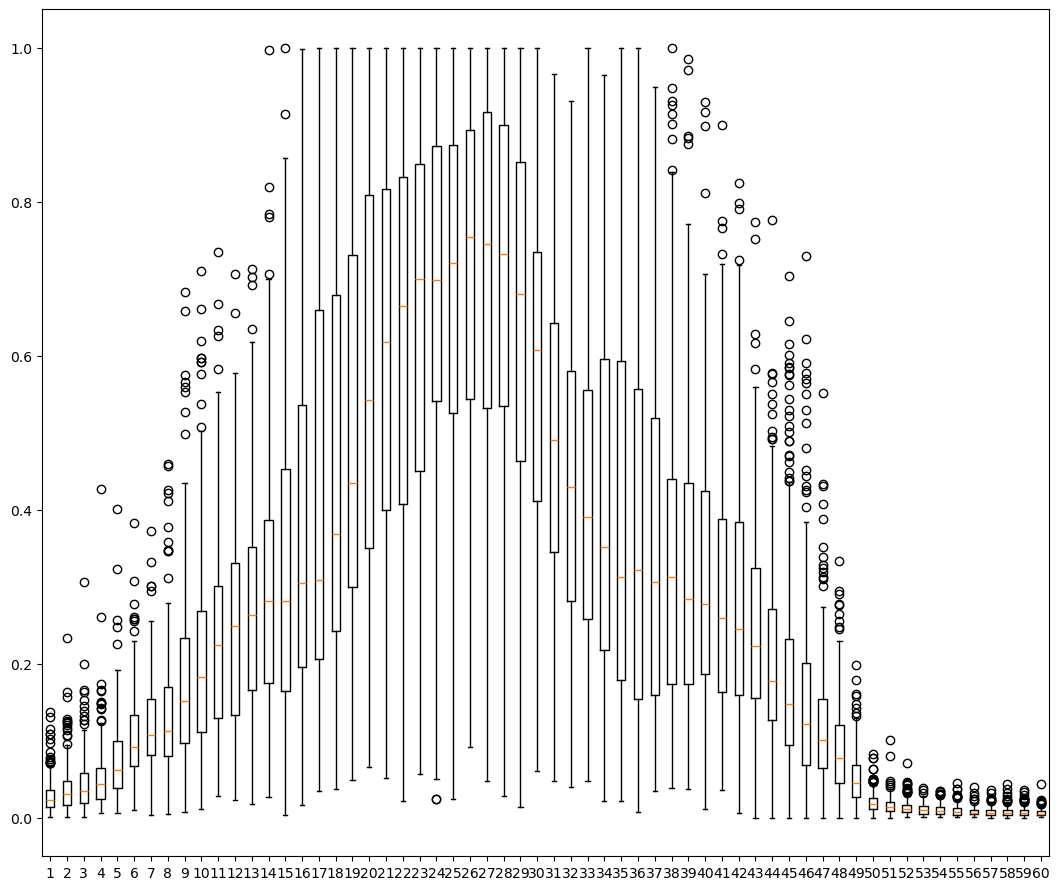

In [28]:
plt.figure(figsize=(13,11))
plt.boxplot(X)
plt.show()

In [41]:
y.value_counts()

60
M    111
R     97
Name: count, dtype: int64

In [30]:
X.shape

(208, 60)

In [75]:
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [47]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

scaler = MinMaxScaler()
encoder = LabelEncoder()

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((166, 60), (42, 60))

In [38]:
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [49]:
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

### Creating Keras Tunner

In [111]:
## Building model Adding
def build_model(hp):
    model = Sequential()
    counter = 0
    no_of_layers = hp.Int("num_layers", min_value=1, max_value=10)

    for i in range(no_of_layers):
        if counter==0:
            model.add(Dense(units=hp.Int("units"+str(i), min_value=8, max_value=128, step=8),
                           activation=hp.Choice("Activation"+str(i), values=["relu","tanh","sigmoid"]),
                           input_dim=60)
                     )
            model.add(Dropout(
                rate=hp.Float('dropout_' + str(i), min_value=0.1, max_value=0.5, step=0.1))
            )
        else:
            model.add(
                Dense(
                    units=hp.Int("units"+str(i), min_value=8, max_value=128, step=8),
                    activation=hp.Choice("Activation"+str(i), values=["relu","tanh","sigmoid"])
                )
            )
            model.add(Dropout(
                rate=hp.Float('dropout_' + str(i), min_value=0.1, max_value=0.5, step=0.1))
            )
        counter+=1

    model.add(Dense(1,activation="sigmoid"))

    optimizer=hp.Choice("optimizer",values=["adam","rmsprop","adadelta","sgd","nadam"])
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

    

In [113]:
tuner = kt.RandomSearch(build_model,
                       objective="val_accuracy",
                       max_trials=5,
                       directory="tuning",
                       project_name="final-model1")

In [115]:
tuner.search(X_train_scaler, y_train,
             epochs=5,
             validation_data=(X_test_scaler, y_test))

Trial 5 Complete [00h 00m 04s]
val_accuracy: 0.6904761791229248

Best val_accuracy So Far: 0.6904761791229248
Total elapsed time: 00h 00m 21s


In [117]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 3,
 'units0': 128,
 'Activation0': 'sigmoid',
 'dropout_0': 0.1,
 'optimizer': 'adam',
 'units1': 8,
 'Activation1': 'tanh',
 'dropout_1': 0.1,
 'units2': 80,
 'Activation2': 'relu',
 'dropout_2': 0.2,
 'units3': 16,
 'Activation3': 'relu',
 'dropout_3': 0.2,
 'units4': 40,
 'Activation4': 'tanh',
 'dropout_4': 0.1,
 'units5': 64,
 'Activation5': 'sigmoid',
 'dropout_5': 0.30000000000000004,
 'units6': 88,
 'Activation6': 'tanh',
 'dropout_6': 0.1,
 'units7': 128,
 'Activation7': 'tanh',
 'dropout_7': 0.4,
 'units8': 104,
 'Activation8': 'sigmoid',
 'dropout_8': 0.2}

In [119]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           7,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 80)                  │             720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              81 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,641 (37.66 KB)

 Trainable params: 9,641 (37.66 KB)

 Non-trainable params: 0 (0.00 B)

In [121]:
model.fit(X_train_scaler, y_train, epochs=100, initial_epoch=5, validation_data=(X_test_scaler, y_test))

Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5402 - loss: 0.6892 - val_accuracy: 0.6190 - val_loss: 0.6731
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5277 - loss: 0.6928 - val_accuracy: 0.6190 - val_loss: 0.6640
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5247 - loss: 0.6878 - val_accuracy: 0.6190 - val_loss: 0.6614
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5472 - loss: 0.6869 - val_accuracy: 0.7143 - val_loss: 0.6806
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5466 - loss: 0.6891 - val_accuracy: 0.6905 - val_loss: 0.6840
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4658 - loss: 0.6983 - val_accuracy: 0.7619 - val_loss: 0.6772
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5527 - loss: 0.6805 - val_accuracy: 0.6429 - val_loss: 0.6593
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5446 - loss: 0.6864 - val_accuracy: 0.6429 - val_l